# Graphing links between SEP articles

This is an excercise graphing relations between articles in the Stanford Encyclopedia of Philosophy. We will use [``networkx``](https://github.com/networkx/networkx) to build a graph object, [``BeautifulSoup``](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to parse the html files, ``requests`` to get the files, and ``matplotlib`` to plot.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup as bs

We will be visiting a random entry in the SEP. We will hard-code this url for this.

In [2]:
url = 'https://plato.stanford.edu/cgi-bin/encyclopedia/random'

We define a function that takes the a url, visits it, processes its content, and gets us a list of links and a title. We pass these to the graph object we will define later.

In [3]:
def get_neighbors(url):
    # Check if we were here before
    if url not in visited:
        # Visit the site
        html = requests.get(url).content

        # Add it to the visited list
        visited.append(url)

        # Parse the html to get the article content
        soup = bs(html, "lxml")
        article = soup.find(id="article-content")

        # Get title and links
        ## Most titles are found in h1 headers.
        ## Some of them, e.g. in supplements, are in h2 headers.
        try:
            title = article.find('h1').text
        except AttributeError:
            try:
                title = article.find('h2').text
                # If none is found, let's move on and exit later.
            except AttributeError:
                title = False

        # If we cannot get the links, let's say it.
        try:
            links = article.find_all('a', href=True)
        except AttributeError:
            print "No links found. Moving on."
            links = False
        
        # If we found the links and the title, we can keep going.
        # We also limit to two levels of depth.
        if not links or len(visited) > 2:
            print "Leaving"
        
        else:
            print "Visiting: %s" % title

            # Add the title to the dictionary to plot later
            labels[url] = title

            # List all the linked articles (leave other links behind)
            linked_articles = []
            for l in links:
                if "../" in l['href']:
                    new_url = 'https://plato.stanford.edu/entries/' + l['href'][3:]

                    # Add the edge to the graph
                    G.add_edge(url, new_url)

                    # Add the link to the list of linked articles to visit later
                    linked_articles.append(new_url)

            # Start visiting new articles
            ## We will visit only the first 2 links. We can change this easily.
            for new_url in linked_articles[:2]:
                get_neighbors(new_url)

            # If still missing titles, get them
            for url in linked_articles:
                if url not in labels.keys():
                    # Visit the site
                    html = requests.get(url).content

                    # Parse the html to get the article content
                    soup = bs(html, "lxml")
                    article = soup.find(id="article-content")

                    # Get title
                    try:
                        title = article.find('h1').text
                        labels[url] = title
                        print "Visiting: %s" % title
                    except:
                        continue
                

Now we define a graph object G. This object takes a dictionary as an input. We also make a list of visited places so we don't visit them again. 

In [4]:
G = nx.Graph()
labels = {}
visited = []

Off we go!

In [5]:
get_neighbors(url)

Visiting: Anaphora
Visiting: Discourse Representation Theory
Leaving
Leaving
Visiting: Anaphora
Visiting: Compositionality
Visiting: Descriptions
Visiting: Indexicals
Visiting: Presupposition
Visiting: Dynamic Semantics
Leaving
Visiting: Situations in Natural Language Semantics


If everything went well, we can plot our graph now. 

{'https://plato.stanford.edu/cgi-bin/encyclopedia/random': Text(-0.0510086,-0.447901,u'Anaphora'),
 'https://plato.stanford.edu/entries/anaphora/': Text(0.555101,0.238994,u'Anaphora'),
 'https://plato.stanford.edu/entries/compositionality/': Text(-0.160285,0.681286,u'Compositionality'),
 'https://plato.stanford.edu/entries/descriptions/': Text(0.297968,0.631864,u'Descriptions'),
 'https://plato.stanford.edu/entries/discourse-representation-theory/': Text(0.0150198,0.158176,u'Discourse Representation Theory'),
 'https://plato.stanford.edu/entries/dynamic-semantics/': Text(0.255311,-0.258286,u'Dynamic Semantics'),
 'https://plato.stanford.edu/entries/indexicals/': Text(-0.497071,0.353464,u'Indexicals'),
 'https://plato.stanford.edu/entries/presupposition/': Text(-0.30903,-0.197596,u'Presupposition'),
 'https://plato.stanford.edu/entries/situations-semantics/': Text(-0.106006,-0.98,u'Situations in Natural Language Semantics')}

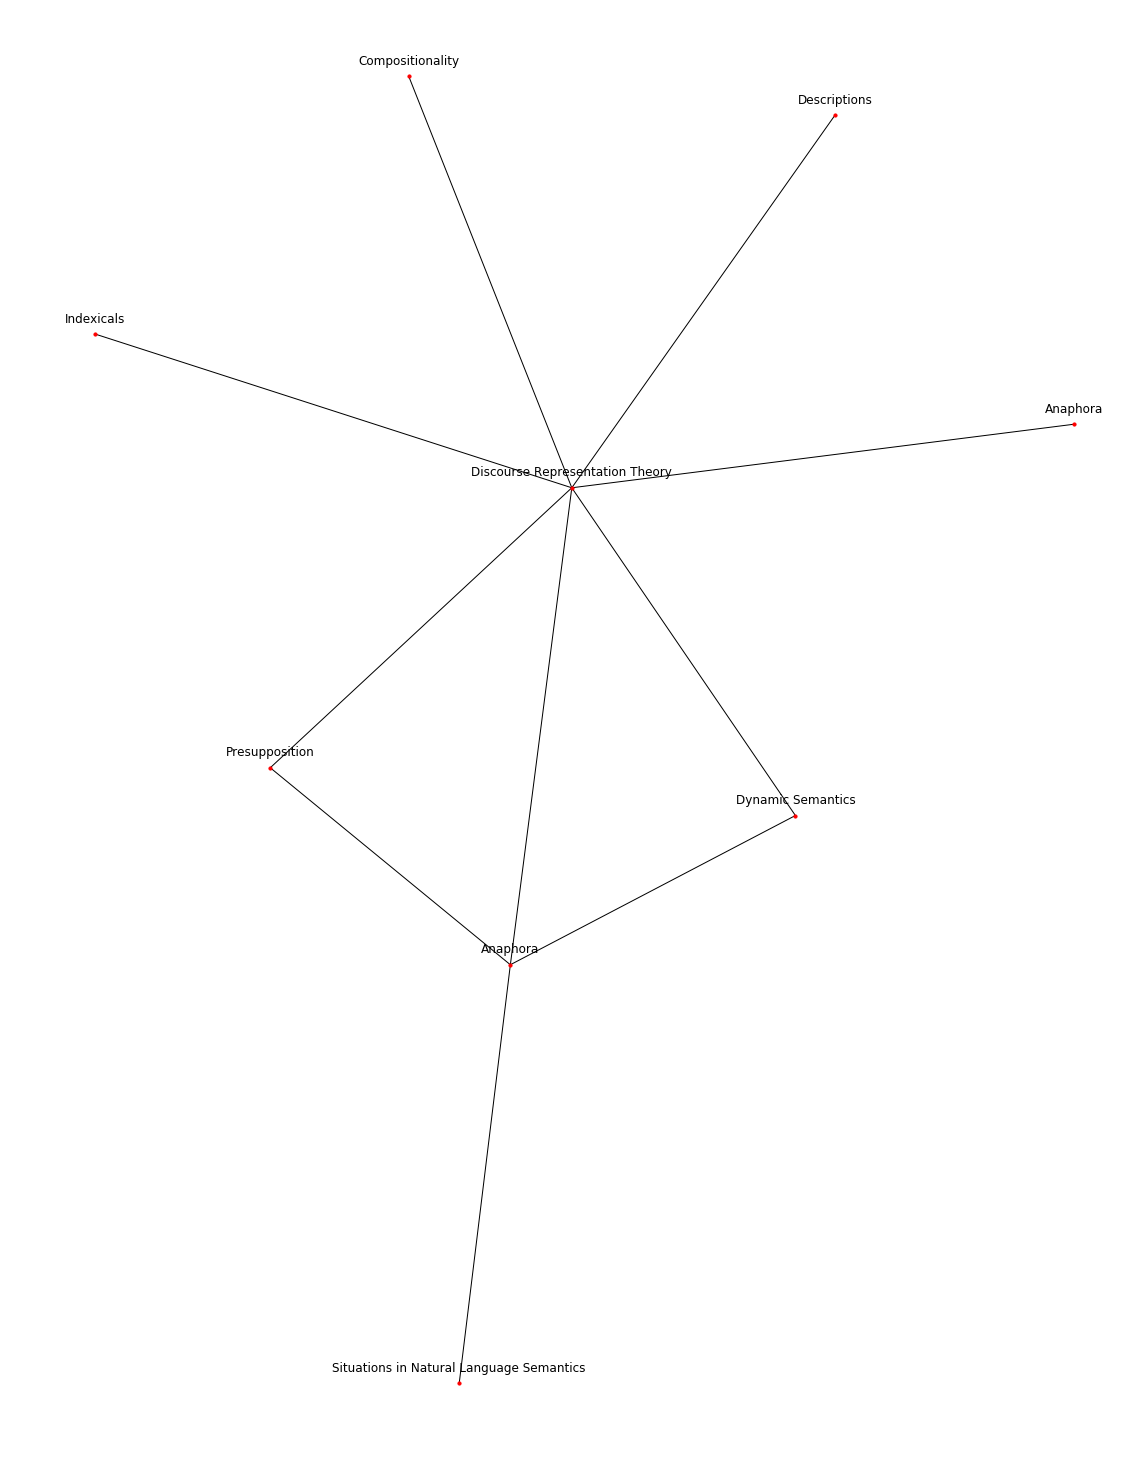

In [6]:
f = plt.figure(figsize=(15,20))
pos=nx.spring_layout(G)
nx.draw(G, pos, node_size=10)
for p in pos:  # raise text positions
        pos[p][1] += 0.02
nx.draw_networkx_labels(G, pos, labels=labels)